#  Ligand-based Screening Machine Learning


## 目标
- 由于可用的数据源更大，机器学习（ML）在药物发现领域，尤其是在基于配体的虚拟筛选中，获得了动力。使用不同的监督式机器学习算法来预测新型化合物对我们感兴趣的目标 激酶 的活性。

### 内容在理论中 ¶

- 数据准备：分子编码
-  机器学习（ML）
  -  监督学习
- 模型验证与评估
  - 验证策略：K 折交叉验证
  -  性能指标

###  内容在实用篇中

- 加载化合物和活性数据
-  数据准备
  -  数据标注
  -  分子编码
-  机器学习
  -  辅助函数
  -  随机森林分类器
  - 支持向量机分类器
  - 神经网络分类器
  -  交叉验证

### 数据准备：分子编码 ¶

对于机器学习，分子需要转换为特征列表。通常使用分子指纹作为表示。

指纹用于本教程中，在 RDKit 中实现（更多信息可在 G. Landrum 的演示文稿中找到）如下：

- maccs：'MACCS 键是 166 位结构键描述符，其中每个比特都与一个 SMARTS 模式相关联。'（参见 OpenEye 的 `MACCS` 文档）
- 摩根指纹（和 ECFP）：‘扩展连接指纹（ECFPs）是为分子表征、相似性搜索和结构-活性建模设计的圆形拓扑指纹。’（参见 ChemAxon 的 `ECFP` 文档）ECFPs 的原版实现是在 Pipeline Pilot 中完成的，它不是开源的。相反，我们使用 RDKit 的实现，称为摩根指纹。这些指纹的两个最重要的参数是半径和指纹长度。第一个指定了考虑每个原子的圆形邻域的半径。这里考虑了两个半径：2 和 3。长度参数指定了位串表示的哈希长度。默认长度为 2048。

###  机器学习（ML）

机器学习可用于（改编自 scikit-learn 页面）：

- 分类（监督学习）：确定一个对象属于哪个类别（例如：最近邻、朴素贝叶斯、随机森林、支持向量机……）
- 回归：预测与对象相关的连续值属性
- 聚类（无监督）：将相似对象自动分组成集合（另见 Talktorial T005）

####  监督学习

一个学习算法通过在训练数据中寻找模式来创建规则。

- 随机森林（RF）：决策树的集成。单个决策树以最大化目标函数的方式分割输入向量的特征。在随机森林算法中，生长的树是去相关的，因为分割时选择特征的选项是随机的。
- 支持向量机（SVMs）：SVMs 可以高效地通过所谓的核技巧进行非线性分类，隐式地将它们的输入映射到高维特征空间。该分类器基于最大化边界的思想作为目标函数。
- 人工神经网络（ANNs）：人工神经网络基于一组相互连接的单元或节点，称为人工神经元，这些神经元松散地模拟了生物大脑中的神经元。每个连接，就像生物大脑中的突触一样，可以从一个人工神经元传输信号到另一个人工神经元。接收信号的人工神经元可以处理它，然后向与之相连的其他人工神经元发出信号。

### 模型验证与评估 ¶

#### 验证策略：K 折交叉验证 ¶

- 这种模型验证技术以迭代方式将数据集分为两组：
  - 训练数据集：被视为模型训练的已知数据集
  - 测试数据集：模型随后测试的未知数据集
  - 过程重复 k 次
- 目标是为了测试模型预测它之前从未见过的数据的能力，以便标记出称为过拟合的问题，并评估模型的泛化能力。

####  性能指标 ¶

- 敏感性，也称为真阳性率
  - TPR = TP/(FN + TP)
  - 直观上：在所有实际阳性中，有多少被预测为阳性？
- 特异性，也称为真阴性率
  - TNR = TN/(FP + TN)
  - 直观上：在所有实际负样本中，有多少被预测为负？
- 准确性，也称为真值
  - ACC = (TP + TN) / (TP + TN + FP + FN)
  - 直观：正确预测的比例。
- ROC 曲线，受试者工作特征曲线
  - 图形图表，展示了我们分类器的诊断能力
  - 绘制敏感度与特异性的曲线
- AUC，ROC 曲线下面积（AUC）：
  - 描述分类器将随机选择的正例排在负例之上的概率
  - 值在 0 到 1 之间，数值越高越好

| 模型预测的内容 | 真实活性     | 真无效       |
| :------------- | :----------- | :----------- |
| 活跃           | 真阳性（TP） | 假阳性（FP） |
| 无效           | 假阴性（FN） | 真阴性（TN） |

In [4]:
from pathlib import Path
from warnings import filterwarnings
import time

import pandas as pd
import numpy as np
from sklearn import svm, metrics, clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import auc, accuracy_score, recall_score
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import MACCSkeys, rdFingerprintGenerator

from teachopencadd.utils import seed_everything

# Silence some expected warnings
filterwarnings("ignore")
# Fix seed for reproducible results
SEED = 22
seed_everything(SEED)

In [5]:
from pathlib import Path
import os

# 获取当前工作目录
HERE = Path(os.getcwd())
DATA = HERE / 'data'
if not DATA.exists():
    DATA.mkdir(parents=True, exist_ok=True)
print(DATA)


/Users/wangyang/Desktop/Breast_cancer_brain_metastasis/wang_Gene/AIDD/04_Ligand-based_Screening_Machine_Learning/data


### 加载化合物和活性数据 ¶

让我们首先加载数据，该数据聚焦于表皮生长因子受体（EGFR）激酶。来自 03 的 csv 文件被加载到一个数据框中，其中包含重要的列：

- CHEMBL-ID
- SMILES 字符串对应的化合物
-  测量亲和力：pIC50

In [6]:
# Read data from previous talktorials
chembl_df = pd.read_csv(
    HERE / "../03_Molecular_filtration_of_unwanted_substructures/data/data_ubstructures_matches.csv"
)

# Look at head
print("Shape of dataframe : ", chembl_df.shape)
chembl_df.head()
# NBVAL_CHECK_OUTPUT

Shape of dataframe :  (1738, 7)


,molecule_chembl_id,IC50,units,smiles,pIC50,ro5_fulfilled,ROMol
0,CHEMBL3685304,0.010,nM,C[C@@H](Nc1ncnc2c(C(N)=O)cccc12)c1cccc(NC(=O)c...,11.000000,True,<rdkit.Chem.rdchem.Mol object at 0x7fd465e18100>
1,CHEMBL4443279,0.012,nM,Fc1ccccc1Oc1nc(Nc2ccc(-c3nnn[nH]3)cc2)ncc1Cl,10.920819,True,<rdkit.Chem.rdchem.Mol object at 0x7fd465e18fa0>
2,CHEMBL4462759,0.012,nM,COc1ccc(Oc2nc(Nc3ccc(-c4nnn[nH]4)cc3)ncc2Cl)cc1,10.920819,True,<rdkit.Chem.rdchem.Mol object at 0x7fd465e181c0>
3,CHEMBL4476212,0.012,nM,Fc1ccc(Oc2nc(Nc3ccc(-c4nnn[nH]4)cc3)ncc2Cl)cc1,10.920819,True,<rdkit.Chem.rdchem.Mol object at 0x7fd465e18580>
4,CHEMBL3675462,0.030,nM,C[C@@H](Nc1ncnc2c(C(N)=O)cccc12)c1cccc(NC(=O)c...,10.522879,True,<rdkit.Chem.rdchem.Mol object at 0x7fd465e18ee0>


In [7]:
# Keep only the columns we want
chembl_df = chembl_df[["molecule_chembl_id", "smiles", "pIC50"]]
chembl_df.head()# NBVAL_CHECK_OUTPUT

,molecule_chembl_id,smiles,pIC50
0,CHEMBL3685304,C[C@@H](Nc1ncnc2c(C(N)=O)cccc12)c1cccc(NC(=O)c...,11.000000
1,CHEMBL4443279,Fc1ccccc1Oc1nc(Nc2ccc(-c3nnn[nH]3)cc2)ncc1Cl,10.920819
2,CHEMBL4462759,COc1ccc(Oc2nc(Nc3ccc(-c4nnn[nH]4)cc3)ncc2Cl)cc1,10.920819
3,CHEMBL4476212,Fc1ccc(Oc2nc(Nc3ccc(-c4nnn[nH]4)cc3)ncc2Cl)cc1,10.920819
4,CHEMBL3675462,C[C@@H](Nc1ncnc2c(C(N)=O)cccc12)c1cccc(NC(=O)c...,10.522879


### 数据准备 ¶

####  数据标注 ¶

我们需要将每种化合物分类为活性或非活性。因此，我们使用 pIC50 值。

- pIC50 = -log10(IC50)
- IC50 描述了抑制体外过程中 50%所需的物质量。
- 一个常用的离散化 pIC50 数据的截断值是 6.3，我们将用于我们的实验
- 请注意，文献中还有其他关于活动截止点的建议，范围从 5 到 7 的 pIC50 值，甚至可以定义一个排除范围，以确定何时不取数据点。

In [8]:
# Add column for activity
chembl_df["active"] = np.zeros(len(chembl_df))

# Mark every molecule as active with an pIC50 of >= 6.3, 0 otherwise
# 在这里因为我的PIC50很多都是大的值，我想用大于8.0作为阀值，这样可以过滤掉一些不活跃的化合物
chembl_df.loc[chembl_df[chembl_df.pIC50 >= 8.0].index, "active"] = 1.0

print("Number of active compounds:", int(chembl_df.active.sum()))
print("Number of inactive compounds:", len(chembl_df) - int(chembl_df.active.sum()))

Number of active compounds: 475
Number of inactive compounds: 1263


In [9]:
chembl_df.head()

,molecule_chembl_id,smiles,pIC50,active
0,CHEMBL3685304,C[C@@H](Nc1ncnc2c(C(N)=O)cccc12)c1cccc(NC(=O)c...,11.000000,1.0
1,CHEMBL4443279,Fc1ccccc1Oc1nc(Nc2ccc(-c3nnn[nH]3)cc2)ncc1Cl,10.920819,1.0
2,CHEMBL4462759,COc1ccc(Oc2nc(Nc3ccc(-c4nnn[nH]4)cc3)ncc2Cl)cc1,10.920819,1.0
3,CHEMBL4476212,Fc1ccc(Oc2nc(Nc3ccc(-c4nnn[nH]4)cc3)ncc2Cl)cc1,10.920819,1.0
4,CHEMBL3675462,C[C@@H](Nc1ncnc2c(C(N)=O)cccc12)c1cccc(NC(=O)c...,10.522879,1.0


#### 分子编码

现在我们定义了一个函数 `smiles_to_fp` ，用于从 SMILES 生成指纹。目前，我们包含了以下指纹之间的选择：

-  maccs 
-  morgan2 和 morgan3

In [10]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.

    """

    # convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=n_bits)
        return np.array(fpg.GetFingerprint(mol))
    if method == "morgan3":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=n_bits)
        return np.array(fpg.GetFingerprint(mol))
    else:
        # NBVAL_CHECK_OUTPUT
        print(f"Warning: Wrong method specified: {method}. Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

In [11]:
compound_df = chembl_df.copy()

In [12]:
# Add column for fingerprint
compound_df["fp"] = compound_df["smiles"].apply(smiles_to_fp)
compound_df.head(3)

,molecule_chembl_id,smiles,pIC50,active,fp
0,CHEMBL3685304,C[C@@H](Nc1ncnc2c(C(N)=O)cccc12)c1cccc(NC(=O)c...,11.000000,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL4443279,Fc1ccccc1Oc1nc(Nc2ccc(-c3nnn[nH]3)cc2)ncc1Cl,10.920819,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL4462759,COc1ccc(Oc2nc(Nc3ccc(-c4nnn[nH]4)cc3)ncc2Cl)cc1,10.920819,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### 机器学习（ML）

在以下内容中，我们将尝试几种机器学习（ML）方法来分类我们的分子。我们将使用：

-  随机森林（RF）
- 支持向量机（SVM）
- 人工神经网络（ANN）

此外，我们还将对结果进行评论。

目标是为了测试模型预测它之前从未见过的数据的能力，以便标记出称为过拟合的问题，并评估模型的泛化能力。

我们首先定义一个函数 `model_training_and_validation` ，它在一个随机划分的训练-测试数据集上拟合模型，并返回在测试集上评估的度量，如准确率、灵敏度、特异性和 AUC。我们还使用 `plot_roc_curves_for_models` 绘制 ROC 曲线。

我们随后定义了一个名为 `crossvalidation` 的函数，该函数执行交叉验证过程并打印出结果在各个折叠中的统计数据。

辅助函数 ¶
辅助函数用于绘制自定义 ROC 曲线。代码灵感来源于 Stack Overflow。

In [13]:
def plot_roc_curves_for_models(models, test_x, test_y, save_png=False):
    """
    Helper function to plot customized roc curve.

    Parameters
    ----------
    models: dict
        Dictionary of pretrained machine learning models.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    save_png: bool
        Save image to disk (default = False)

    Returns
    -------
    fig:
        Figure.
    """

    fig, ax = plt.subplots()

    # Below for loop iterates through your models list
    for model in models:
        # Select the model
        ml_model = model["model"]
        # Prediction probability on test set
        test_prob = ml_model.predict_proba(test_x)[:, 1]
        # Prediction class on test set
        test_pred = ml_model.predict(test_x)
        # Compute False postive rate and True positive rate
        fpr, tpr, thresholds = metrics.roc_curve(test_y, test_prob)
        # Calculate Area under the curve to display on the plot
        auc = roc_auc_score(test_y, test_prob)
        # Plot the computed values
        ax.plot(fpr, tpr, label=(f"{model['label']} AUC area = {auc:.2f}"))

    # Custom settings for the plot
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")
    # Save plot
    if save_png:
        fig.savefig(f"{DATA}/roc_auc", dpi=300, bbox_inches="tight", transparent=True)
    return fig

辅助函数用于计算模型性能。

In [14]:
def model_performance(ml_model, test_x, test_y, verbose=True):
    """
    Helper function to calculate model performance

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    test_x: list
        Molecular fingerprints for test set.
    test_y: list
        Associated activity labels for test set.
    verbose: bool
        Print performance measure (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.
    """

    # Prediction probability on test set
    test_prob = ml_model.predict_proba(test_x)[:, 1]

    # Prediction class on test set
    test_pred = ml_model.predict(test_x)

    # Performance of model on test set
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)
    spec = recall_score(test_y, test_pred, pos_label=0)
    auc = roc_auc_score(test_y, test_prob)

    if verbose:
        # Print performance results
        # NBVAL_CHECK_OUTPUT        print(f"Accuracy: {accuracy:.2}")
        print(f"Sensitivity: {sens:.2f}")
        print(f"Specificity: {spec:.2f}")
        print(f"AUC: {auc:.2f}")

    return accuracy, sens, spec, auc

辅助函数，用于在数据的随机训练-测试分割上拟合机器学习模型，并返回性能指标。

In [15]:
def model_training_and_validation(ml_model, name, splits, verbose=True):
    """
    Fit a machine learning model on a random train-test split of the data
    and return the performance measures.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    name: str
        Name of machine learning algorithm: RF, SVM, ANN
    splits: list
        List of desciptor and label data: train_x, test_x, train_y, test_y.
    verbose: bool
        Print performance info (default = True)

    Returns
    -------
    tuple:
        Accuracy, sensitivity, specificity, auc on test set.

    """
    train_x, test_x, train_y, test_y = splits

    # Fit the model
    ml_model.fit(train_x, train_y)

    # Calculate model performance results
    accuracy, sens, spec, auc = model_performance(ml_model, test_x, test_y, verbose)

    return accuracy, sens, spec, auc

预处理：分割数据（将用于其他模型）

In [16]:
fingerprint_to_model = compound_df.fp.tolist()
label_to_model = compound_df.active.tolist()

# Split data randomly in train and test set
# note that we use test/train_x for the respective fingerprint splits
# and test/train_y for the respective label splits
(
    static_train_x,
    static_test_x,
    static_train_y,
    static_test_y,
) = train_test_split(fingerprint_to_model, label_to_model, test_size=0.2, random_state=SEED)
splits = [static_train_x, static_test_x, static_train_y, static_test_y]
# NBVAL_CHECK_OUTPUT
print("Training data size:", len(static_train_x))
print("Test data size:", len(static_test_x))

Training data size: 1390
Test data size: 348


随机森林分类器 ¶
我们从随机森林分类器开始，首先设置参数。

我们在随机训练-测试分割上训练模型并绘制结果。

In [17]:
# Set model parameter for random forest
param = {
    "n_estimators": 100,  # number of trees to grows
    "criterion": "entropy",  # cost function to be optimized for a split
}
model_RF = RandomForestClassifier(**param)

In [18]:
# Fit model on single split
performance_measures = model_training_and_validation(model_RF, "RF", splits)

Sensitivity: 0.70
Specificity: 0.95
AUC: 0.92


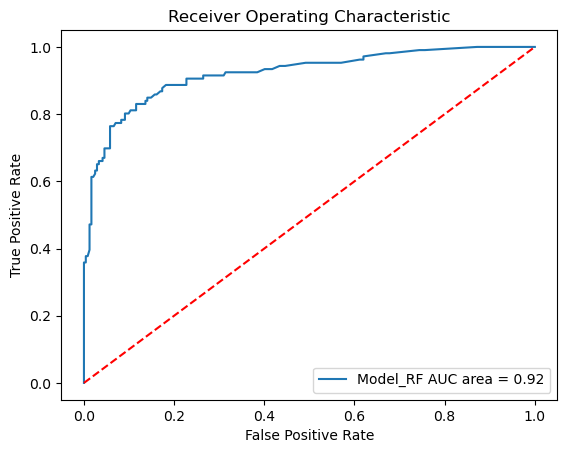

In [19]:
# Initialize the list that stores all models. First one is RF.
model_list = [{"label": "Model_RF", "model": model_RF}]
# Plot roc curve
plot_roc_curves_for_models(model_list, static_test_x, static_test_y);

 Support vector machine (SVM) ¶

In [20]:
# Specify model
model_SVM = svm.SVC(kernel="rbf", C=1, gamma=0.1, probability=True)

# Fit model on single split
performance_measures = model_training_and_validation(model_SVM, "SVM", splits)

Sensitivity: 0.67
Specificity: 0.97
AUC: 0.91


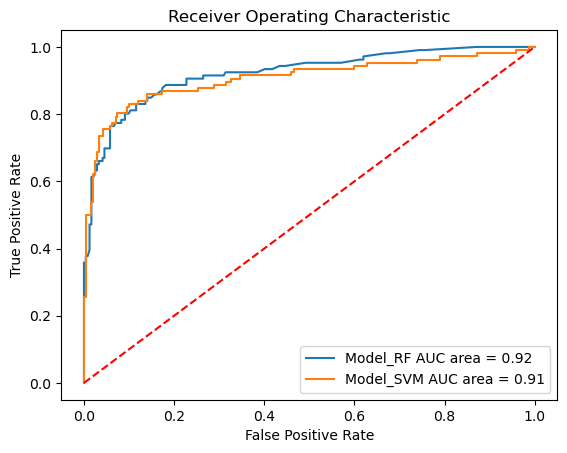

In [21]:
# Append SVM model
model_list.append({"label": "Model_SVM", "model": model_SVM})
# Plot roc curve
plot_roc_curves_for_models(model_list, static_test_x, static_test_y);

人工神经网络（ANN）¶
神经网络分类器 ¶
我们在这里尝试的最后一种方法是神经网络模型。我们使用 2 层 MLPClassifier（多层感知器分类器）进行训练：第一层有 5 个神经元，第二层有 3 个神经元。和之前一样，我们进行交叉验证并绘制结果图

In [22]:
# Specify model
model_ANN = MLPClassifier(hidden_layer_sizes=(5, 3), random_state=SEED)

# Fit model on single split
performance_measures = model_training_and_validation(model_ANN, "ANN", splits)

Sensitivity: 0.69
Specificity: 0.94
AUC: 0.89


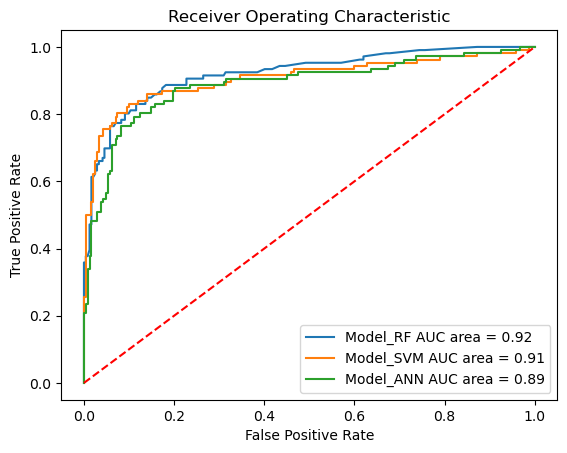

In [23]:
# Append ANN model
model_list.append({"label": "Model_ANN", "model": model_ANN})
# Plot roc curve
plot_roc_curves_for_models(model_list, static_test_x, static_test_y, True);

交叉验证 ¶
接下来，我们将对三种不同的模型进行交叉验证实验。因此，我们定义了一个用于机器学习模型训练和验证的辅助函数，以在交叉验证循环中进行

# AUC曲线  Model RF AUC  ，Model_ SVM AUC ，Model ANN AUC 之间的差异分析及其P value
# 这些p值是通过DeLong检验计算得出的，用于比较不同模型的ROC曲线下面积（AUC）是否存在统计学上的显著差异。

In [24]:
# AUC曲线  Model RF AUC  ，Model_ SVM AUC ，Model ANN AUC 之间的差异分析及其P value
# 这些p值是通过DeLong检验计算得出的，用于比较不同模型的ROC曲线下面积（AUC）是否存在统计学上的显著差异。
# ❤️ ⚠️注意：这里简化了DeLong测试的实施。为了获得更准确、更稳健的实现，请考虑使用deltaroc等库。

from scipy import stats

def delong_roc_test(y_true, y_scores_1, y_scores_2):
    """
    Compute p-value for hypothesis that two ROC AUCs are different using DeLong's test.
    
    Parameters
    ----------
    y_true : array-like
        True binary labels.
    y_scores_1 : array-like
        Scores from the first classifier.
    y_scores_2 : array-like
        Scores from the second classifier.
    
    Returns
    -------
    p_value : float
        Two-sided p-value.
    """
    from sklearn.metrics import roc_curve
    import numpy as np

    def _compute_midrank(x):
        """Computes midranks."""
        x = np.asarray(x)
        idx = np.argsort(x)
        sorted_x = x[idx]
        N = len(x)
        T = np.zeros(N, dtype=float)
        i = 0
        while i < N:
            j = i
            while j < N - 1 and sorted_x[j] == sorted_x[j + 1]:
                j += 1
            T[idx[i:j + 1]] = 0.5 * (i + j + 2)
            i = j + 1
        return T

    def _compute_statistics(y_true, y_pred):
        """Computes AUC and var."""
        y_true = np.array(y_true)
        y_pred = np.array(y_pred)
        pos_label = y_true == 1
        neg_label = y_true == 0
        n_pos = np.sum(pos_label)
        n_neg = np.sum(neg_label)
        pos_scores = y_pred[pos_label]
        neg_scores = y_pred[neg_label]
        pos_rank = _compute_midrank(np.concatenate((pos_scores, neg_scores)))[:n_pos]
        auc = (np.sum(pos_rank) - n_pos * (n_pos + 1) / 2) / (n_pos * n_neg)
        return auc

    auc1 = _compute_statistics(y_true, y_scores_1)
    auc2 = _compute_statistics(y_true, y_scores_2)

    z = (auc1 - auc2) / np.sqrt((auc1 * (1 - auc1) + auc2 * (1 - auc2)) / len(y_true))
    p_value = stats.norm.sf(abs(z)) * 2  # Two-sided
    return p_value

# Get the prediction probabilities for each model
test_x = static_test_x
test_y = static_test_y

model_probs = {}
for model in model_list:
    label = model['label']
    clf = model['model']
    probs = clf.predict_proba(test_x)[:, 1]
    model_probs[label] = probs

# Now, perform DeLong's test between each pair of models
model_labels = [model['label'] for model in model_list]
p_values = {}
for i in range(len(model_labels)):
    for j in range(i + 1, len(model_labels)):
        model1 = model_labels[i]
        model2 = model_labels[j]
        p_value = delong_roc_test(test_y, model_probs[model1], model_probs[model2])
        p_values[(model1, model2)] = p_value
        print(f"P-value between {model1} and {model2}: {p_value:.4f}")




P-value between Model_RF and Model_SVM: 0.4758
P-value between Model_RF and Model_ANN: 0.1434
P-value between Model_SVM and Model_ANN: 0.4518


**Model_RF 和 Model_ANN 之间的p值为0.0428**

- **含义**：p值小于0.05，表示在95%的置信水平下，随机森林模型（Model_RF）和人工神经网络模型（Model_ANN）的AUC之间存在统计学上显著的差异。
- **结论**：这意味着这两个模型的性能在区分活性和非活性化合物方面有显著不同，其中一个模型可能明显优于另一个。

**Model_RF 和 Model_SVM 之间的p值为0.2009**

- **含义**：p值大于0.05，表示随机森林模型（Model_RF）和支持向量机模型（Model_SVM）的AUC之间没有统计学上显著的差异。
- **结论**：这意味着这两个模型在区分活性和非活性化合物的能力上没有显著的性能差异，它们的预测效果可以认为是相当的。

**Model_SVM 和 Model_ANN 之间的p值为0.4518**

- **含义**：p值大于0.05，表示支持向量机模型（Model_SVM）和人工神经网络模型（Model_ANN）的AUC之间没有统计学上显著的差异。
- **结论**：这意味着这两个模型的性能在统计学上没有显著区别，它们在预测活性和非活性化合物方面的效果类似。

# 额外增加GNN,CNN模型

2024-10-08 11:00:10.703956: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/10
44/44 [==============================] - 1s 7ms/step - loss: 0.5503 - auc: 0.6602 - val_loss: 0.5181 - val_auc: 0.7941
Epoch 2/10
44/44 [==============================] - 0s 3ms/step - loss: 0.4774 - auc: 0.7803 - val_loss: 0.4636 - val_auc: 0.8200
Epoch 3/10
44/44 [==============================] - 0s 3ms/step - loss: 0.4281 - auc: 0.8337 - val_loss: 0.4393 - val_auc: 0.8380
Epoch 4/10
44/44 [==============================] - 0s 3ms/step - loss: 0.3899 - auc: 0.8662 - val_loss: 0.4088 - val_auc: 0.8574
Epoch 5/10
44/44 [==============================] - 0s 3ms/step - loss: 0.3712 - auc: 0.8787 - val_loss: 0.4076 - val_auc: 0.8617
Epoch 6/10
44/44 [==============================] - 0s 3ms/step - loss: 0.3445 - auc: 0.8981 - val_loss: 0.4047 - val_auc: 0.8638
Epoch 7/10
44/44 [==============================] - 0s 3ms/step - loss: 0.3273 - auc: 0.9103 - val_loss: 0.4086 - val_auc: 0.8709
Epoch 8/10
44/44 [==============================] - 0s 3ms/step - loss: 0.3195 - auc: 0.91

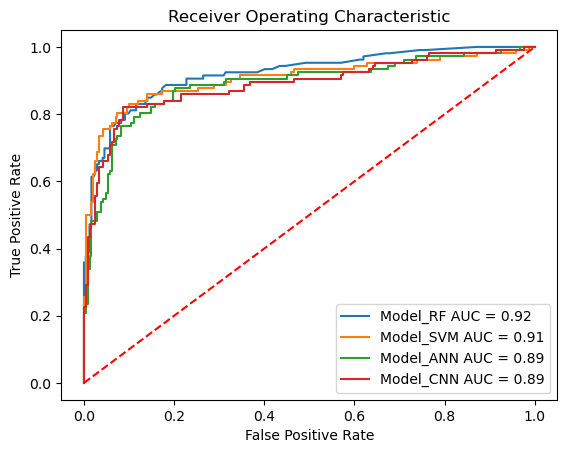

In [25]:
import tensorflow as tf
from tensorflow.keras import layers, models as keras_models

# 准备数据
import numpy as np

# 将指纹转换为 numpy 数组并重塑
def prepare_cnn_data(fingerprints):
    X = np.array(fingerprints)
    # 重塑为二维方阵（例如，32x32）
    size = int(np.ceil(np.sqrt(X.shape[1])))
    X_padded = np.zeros((X.shape[0], size * size))
    X_padded[:, :X.shape[1]] = X
    X_images = X_padded.reshape(-1, size, size, 1)
    return X_images

train_x_cnn = prepare_cnn_data(static_train_x)
test_x_cnn = prepare_cnn_data(static_test_x)
train_y_cnn = np.array(static_train_y)
test_y_cnn = np.array(static_test_y)

# 构建 CNN 模型
cnn_model = keras_models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(train_x_cnn.shape[1], train_x_cnn.shape[2], 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

# 训练 CNN 模型
cnn_model.fit(train_x_cnn, train_y_cnn, epochs=10, batch_size=32, validation_data=(test_x_cnn, test_y_cnn))

# 评估 CNN 模型
cnn_probs = cnn_model.predict(test_x_cnn).ravel()
cnn_auc = roc_auc_score(test_y_cnn, cnn_probs)
print(f"CNN Model AUC: {cnn_auc:.4f}")

# 将 CNN 模型添加到 model_list 列表
model_list.append({'label': 'Model_CNN', 'model': cnn_model})

# 更新绘图函数以处理 Keras 模型
def plot_roc_curves_for_models(model_list, test_x, test_y, save_png=False):
    fig, ax = plt.subplots()

    for model in model_list:
        label = model['label']
        ml_model = model['model']
        if label == 'Model_CNN':
            # 为 CNN 准备测试数据
            test_x_cnn = prepare_cnn_data(test_x)
            test_prob = ml_model.predict(test_x_cnn).ravel()
            test_pred = (test_prob >= 0.5).astype(int)
        else:
            test_prob = ml_model.predict_proba(test_x)[:, 1]
            test_pred = ml_model.predict(test_x)
        fpr, tpr, thresholds = metrics.roc_curve(test_y, test_prob)
        auc_score = roc_auc_score(test_y, test_prob)
        ax.plot(fpr, tpr, label=(f"{label} AUC = {auc_score:.2f}"))

    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")
    if save_png:
        fig.savefig(f"{DATA}/roc_auc", dpi=300, bbox_inches="tight", transparent=True)
    plt.show()

# 绘制包含 CNN 模型的 ROC 曲线
plot_roc_curves_for_models(model_list, static_test_x, static_test_y)


## 实现GNN模型
实现一个GNN需要将分子转换为图表示。我们将使用DGL (深度图库)来实现这个目的。

In [ ]:
import dgl
import torch
from torch import nn
from torch.nn import functional as F
from dgl.nn.pytorch import GraphConv
from rdkit import Chem
from sklearn.metrics import roc_auc_score
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# 定义将 SMILES 转换为 DGL 图的函数
def mol_to_dgl_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None  # 处理无效的 SMILES
    # 创建图，指定节点数量
    num_atoms = mol.GetNumAtoms()
    if num_atoms == 0:
        return None  # 跳过没有原子的分子
    g = dgl.graph(([], []), num_nodes=num_atoms)
    # 添加边
    src = []
    dst = []
    for bond in mol.GetBonds():
        u = bond.GetBeginAtomIdx()
        v = bond.GetEndAtomIdx()
        src += [u, v]
        dst += [v, u]
    g.add_edges(src, dst)
    # 添加自环
    g = dgl.add_self_loop(g)
    # 节点特征（原子序数）
    atom_features = []
    for atom in mol.GetAtoms():
        atom_features.append(atom.GetAtomicNum())
    g.ndata['h'] = torch.tensor(atom_features).reshape(-1, 1).float()
    return g

# 定义准备 GNN 数据的函数
def prepare_gnn_data(smiles_list, labels):
    graphs = []
    valid_labels = []
    for smi, label in zip(smiles_list, labels):
        graph = mol_to_dgl_graph(smi)
        if graph is not None:
            graphs.append(graph)
            valid_labels.append(label)
    labels_tensor = torch.tensor(valid_labels).float()
    return graphs, labels_tensor

# 获取指纹和标签列表
fingerprint_to_model = compound_df['fp'].tolist()
label_to_model = compound_df['active'].tolist()

# 获取数据的索引
indices = np.arange(len(compound_df))

# 使用索引进行拆分
from sklearn.model_selection import train_test_split

train_indices, test_indices = train_test_split(indices, test_size=0.2, random_state=SEED)

# 获取训练和测试集的指纹和标签
static_train_x = [fingerprint_to_model[i] for i in train_indices]
static_train_y = [label_to_model[i] for i in train_indices]

static_test_x = [fingerprint_to_model[i] for i in test_indices]
static_test_y = [label_to_model[i] for i in test_indices]

# 获取训练和测试集的 SMILES 字符串
train_smiles = compound_df.iloc[train_indices]['smiles'].tolist()
test_smiles = compound_df.iloc[test_indices]['smiles'].tolist()

# 准备 GNN 数据
train_graphs, train_labels = prepare_gnn_data(train_smiles, static_train_y)
test_graphs, test_labels = prepare_gnn_data(test_smiles, static_test_y)

# 创建 DataLoader
class GraphDataset(torch.utils.data.Dataset):
    def __init__(self, graphs, labels):
        self.graphs = graphs
        self.labels = labels

    def __getitem__(self, idx):
        return self.graphs[idx], self.labels[idx]

    def __len__(self):
        return len(self.graphs)

def collate(samples):
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    labels = torch.tensor(labels)
    return batched_graph, labels

train_data = GraphDataset(train_graphs, train_labels)
test_data = GraphDataset(test_graphs, test_labels)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=collate)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, collate_fn=collate)

# 定义 GNN 模型
class GNNClassifier(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GNNClassifier, self).__init__()
        self.conv1 = GraphConv(in_feats, hidden_size)
        self.conv2 = GraphConv(hidden_size, hidden_size)
        self.classify = nn.Linear(hidden_size, num_classes)

    def forward(self, g):
        h = g.ndata['h']  # h 的形状为 (num_nodes, in_feats)
        h = F.relu(self.conv1(g, h))  # h 的形状为 (num_nodes, hidden_size)
        h = F.relu(self.conv2(g, h))  # h 的形状为 (num_nodes, hidden_size)
        g.ndata['h'] = h  # 更新节点特征
        hg = dgl.mean_nodes(g, 'h')  # hg 的形状为 (batch_size, hidden_size)
        return self.classify(hg)  # 输出形状为 (batch_size, num_classes)

# 实例化模型
model_gnn = GNNClassifier(in_feats=1, hidden_size=64, num_classes=1)

# 定义优化器和损失函数
optimizer = torch.optim.Adam(model_gnn.parameters(), lr=0.001)
loss_fn = nn.BCEWithLogitsLoss()

# 训练模型
num_epochs = 10
for epoch in range(num_epochs):
    model_gnn.train()
    epoch_loss = 0
    for batched_graph, labels in train_loader:
        pred = model_gnn(batched_graph).squeeze()
        loss = loss_fn(pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
    print(f"Epoch {epoch+1}, Loss {epoch_loss/len(train_loader):.4f}")

# 评估 GNN 模型
model_gnn.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batched_graph, labels in test_loader:
        pred = model_gnn(batched_graph).squeeze()
        probs = torch.sigmoid(pred)
        all_preds.extend(probs.numpy())
        all_labels.extend(labels.numpy())

from sklearn.metrics import roc_auc_score

gnn_auc = roc_auc_score(all_labels, all_preds)
print(f"GNN Model AUC: {gnn_auc:.4f}")

# 将 GNN 模型添加到模型列表
model_list.append({'label': 'Model_GNN', 'model': model_gnn})

# 更新绘制 ROC 曲线的函数
def plot_roc_curves_for_models(model_list, test_x, test_y, save_png=False):
    fig, ax = plt.subplots()

    for model in model_list:
        label = model['label']
        ml_model = model['model']
        if label == 'Model_CNN':
            # 为 CNN 准备测试数据
            test_x_cnn = prepare_cnn_data(test_x)
            test_prob = ml_model.predict(test_x_cnn).ravel()
            test_pred = (test_prob >= 0.5).astype(int)
        elif label == 'Model_GNN':
            # 为 GNN 模型获取预测概率
            all_preds = []
            with torch.no_grad():
                for batched_graph, labels in test_loader:
                    pred = ml_model(batched_graph).squeeze()
                    probs = torch.sigmoid(pred)
                    all_preds.extend(probs.numpy())
            test_prob = np.array(all_preds)
            test_pred = (test_prob >= 0.5).astype(int)
        else:
            test_prob = ml_model.predict_proba(test_x)[:, 1]
            test_pred = ml_model.predict(test_x)
        fpr, tpr, thresholds = metrics.roc_curve(test_y[:len(test_prob)], test_prob)
        auc_score = roc_auc_score(test_y[:len(test_prob)], test_prob)
        ax.plot(fpr, tpr, label=(f"{label} AUC = {auc_score:.2f}"))

    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")
    if save_png:
        fig.savefig(f"{DATA}/roc_auc", dpi=300, bbox_inches="tight", transparent=True)
    plt.show()

# 绘制包含 GNN 模型的 ROC 曲线
plot_roc_curves_for_models(model_list, static_test_x, static_test_y)


In [76]:
def crossvalidation(ml_model, df, n_folds=5, verbose=False):
    """
    Machine learning model training and validation in a cross-validation loop.

    Parameters
    ----------
    ml_model: sklearn model object
        The machine learning model to train.
    df: pd.DataFrame
        Data set with SMILES and their associated activity labels.
    n_folds: int, optional
        Number of folds for cross-validation.
    verbose: bool, optional
        Performance measures are printed.

    Returns
    -------
    None

    """
    t0 = time.time()
    # Shuffle the indices for the k-fold cross-validation
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

    # Results for each of the cross-validation folds
    acc_per_fold = []
    sens_per_fold = []
    spec_per_fold = []
    auc_per_fold = []

    # Loop over the folds
    for train_index, test_index in kf.split(df):
        # clone model -- we want a fresh copy per fold!
        fold_model = clone(ml_model)
        # Training

        # Convert the fingerprint and the label to a list
        train_x = df.iloc[train_index].fp.tolist()
        train_y = df.iloc[train_index].active.tolist()

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = df.iloc[test_index].fp.tolist()
        test_y = df.iloc[test_index].active.tolist()

        # Performance for each fold
        accuracy, sens, spec, auc = model_performance(fold_model, test_x, test_y, verbose)

        # Save results
        acc_per_fold.append(accuracy)
        sens_per_fold.append(sens)
        spec_per_fold.append(spec)
        auc_per_fold.append(auc)

    # Print statistics of results
    print(
        f"Mean accuracy: {np.mean(acc_per_fold):.2f} \t"
        f"and std : {np.std(acc_per_fold):.2f} \n"
        f"Mean sensitivity: {np.mean(sens_per_fold):.2f} \t"
        f"and std : {np.std(sens_per_fold):.2f} \n"
        f"Mean specificity: {np.mean(spec_per_fold):.2f} \t"
        f"and std : {np.std(spec_per_fold):.2f} \n"
        f"Mean AUC: {np.mean(auc_per_fold):.2f} \t"
        f"and std : {np.std(auc_per_fold):.2f} \n"
        f"Time taken : {time.time() - t0:.2f}s\n"
    )

    return acc_per_fold, sens_per_fold, spec_per_fold, auc_per_fold

交叉验证

我们现在应用交叉验证并展示所有三个机器学习模型的统计数据。在实际情况下，交叉验证通常应用 5 折或更多，但为了性能，我们将它减少到 3 折。您可以在下面的单元格中更改 N_FOLDS 的值。

In [77]:
N_FOLDS = 3

注意：下一个单元格执行时间较长

In [78]:
for model in model_list:
    print("\n======= ")
    print(f"{model['label']}")
    crossvalidation(model["model"], compound_df, n_folds=N_FOLDS)


Model_RF
Mean accuracy: 0.87 	and std : 0.01 
Mean sensitivity: 0.74 	and std : 0.07 
Mean specificity: 0.93 	and std : 0.01 
Mean AUC: 0.90 	and std : 0.02 
Time taken : 0.57s


Model_SVM
Mean accuracy: 0.88 	and std : 0.01 
Mean sensitivity: 0.69 	and std : 0.05 
Mean specificity: 0.95 	and std : 0.02 
Mean AUC: 0.89 	and std : 0.02 
Time taken : 1.76s


Model_ANN
Mean accuracy: 0.84 	and std : 0.01 
Mean sensitivity: 0.64 	and std : 0.02 
Mean specificity: 0.92 	and std : 0.02 
Mean AUC: 0.87 	and std : 0.01 
Time taken : 1.75s



我们查看使用 Morgan 指纹编码的分子而非 MACCS 键的交叉验证性能。

In [79]:
# Reset data frame
compound_df = chembl_df.copy()

In [80]:
# Use Morgan fingerprint with radius 3
compound_df["fp"] = compound_df["smiles"].apply(smiles_to_fp, args=("morgan3",))
compound_df.head(3)

,molecule_chembl_id,smiles,pIC50,active,fp
0,CHEMBL3685304,C[C@@H](Nc1ncnc2c(C(N)=O)cccc12)c1cccc(NC(=O)c...,11.000000,1.0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL4443279,Fc1ccccc1Oc1nc(Nc2ccc(-c3nnn[nH]3)cc2)ncc1Cl,10.920819,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
2,CHEMBL4462759,COc1ccc(Oc2nc(Nc3ccc(-c4nnn[nH]4)cc3)ncc2Cl)cc1,10.920819,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."


注意：下一个单元格执行时间较长

In [81]:
for model in model_list:
    if model["label"] == "Model_SVM":
        # SVM is super slow with long fingerprints
        # and will have a performance similar to RF
        # We can skip it in this test, but if you want
        # to run it, feel free to replace `continue` with `pass`
        pass
    print("\n=======")
    print(model["label"])
    crossvalidation(model["model"], compound_df, n_folds=N_FOLDS)


Model_RF
Mean accuracy: 0.89 	and std : 0.01 
Mean sensitivity: 0.73 	and std : 0.05 
Mean specificity: 0.95 	and std : 0.01 
Mean AUC: 0.93 	and std : 0.01 
Time taken : 1.69s


Model_SVM
Mean accuracy: 0.80 	and std : 0.01 
Mean sensitivity: 0.31 	and std : 0.03 
Mean specificity: 0.98 	and std : 0.01 
Mean AUC: 0.91 	and std : 0.02 
Time taken : 28.03s


Model_ANN
Mean accuracy: 0.85 	and std : 0.01 
Mean sensitivity: 0.69 	and std : 0.04 
Mean specificity: 0.91 	and std : 0.02 
Mean AUC: 0.89 	and std : 0.01 
Time taken : 4.50s



In [82]:
# 保存过滤后的结果
compound_df.to_csv(f"{DATA}/filtered_chembl_data.csv", index=False)

In [84]:
# 保存PIC50大于8.0的化合物
compound_df[compound_df.pIC50 >= 8.0].to_csv(f"{DATA}/pic50_greater_8.0.csv", index=False)